In [10]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score , hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time



In [11]:
class MyDecisionTreeClassifier:
    def __init__(self):
        self.model = DecisionTreeClassifier()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
class MyLogisticClassifier:
    def __init__(self, num_classes=9, learning_rate=0.005, num_epochs=5000):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights = None
        self.bias = None

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_pred.shape[0]
        return -np.sum(np.log(y_pred) * y_true) / m

    def fit(self, X_train, y_train):
        m, n = X_train.shape
        self.weights = np.zeros((n, self.num_classes))
        self.bias = np.zeros((1, self.num_classes))

        for epoch in range(self.num_epochs):
            z = np.dot(X_train, self.weights) + self.bias
            y_pred = self.softmax(z)

            y_train_encoded = np.eye(self.num_classes)[y_train]  # One-hot encoding
            loss = self.cross_entropy_loss(y_pred, y_train_encoded)

            dz = y_pred - y_train_encoded
            dw = np.dot(X_train.T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return np.argmax(y_pred, axis=1)

class MyMLPClassifier(object):
    def __init__(self, learning_rate=0.001,epochs = 5000, inputLayerSize: int = 12, hiddenLayerSize = [21] , outputLayerSize: int = 9):
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.activation = self.sigmoid
        self.activationPrime = self.sigmoidPrime
        self.learning_rate = learning_rate
        self.num_layers = len(hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        self.optimizer = 'SGD'
        self.max_iterations = epochs

    def forward(self, X):
        self.z = [None] * (len(self.weights))
        self.a = [None] * (len(self.weights)-1)
        
        self.z[0] = np.dot(X, self.weights[0])
        for i in range(0,len(self.a)):
            self.a[i] = self.activation(self.z[i])
            self.z[i+1] = np.dot(self.a[i],self.weights[i+1])
        yHat = self.softmax(self.z[-1])
        return yHat

    def relu(self, z):
        return np.maximum(0, z)  # ReLU activation

    def tanh(self, z):
        return np.tanh(z)  # Tanh activation

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoidPrime(self, z):
        return np.exp(-z) / ((1 + np.exp(-z))**2)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))  # Subtracting max(z) for numerical stability
        return exp_z / exp_z.sum(axis=1, keepdims=True)

    def costFunction(self, X, y):
        self.yHat = self.forward(X)
        J = -np.sum(y * np.log(self.yHat)) / len(X)
        return J

    def costFunctionPrime(self, X, y):
        self.yHat = self.forward(X)
        deltas = [None] * (len(self.weights))
        deltas[-1] = self.yHat - y
        dJdWs = [None] * (len(self.weights))
        for i in range(len(deltas)-2,-1,-1):
            dJdWs[i+1] = np.dot(self.a[i].T, deltas[i+1])
            deltas[i] = np.dot(deltas[i+1],self.weights[i+1].T)*self.activationPrime(self.z[i])
        dJdWs[0] = np.dot(X.T, deltas[0])
        return dJdWs

    def reluPrime(self, z):
        return np.where(z > 0, 1, 0)  # Derivative of ReLU

    def tanhPrime(self, z):
        return 1 - np.tanh(z)**2  # Derivative of Tanh

    def backward(self, X, y, learning_rate):
        dJdWs = self.costFunctionPrime(X, y)
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dJdWs[i]
    def fit(self, X, y, batch_size = 32, learning_rate=0.1, max_iterations=10000,wand = 0):
        if(self.optimizer == 'SGD'):
            return self.train_sgd(X=X, y=y,wand=wand)
        elif(self.optimizer == 'Batch'):
            return self.train_batch(X=X, y=y,wand=wand)
        elif(self.optimizer == 'MiniBatch'):
            return self.train_mini_batch(X=X, y=y,wand=wand)
    def train_sgd(self, X, y, learning_rate=0.1, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on MLP Classifier for WineQT Dataset")
        for i in range(self.max_iterations):
            idx = np.random.randint(len(X))
            self.backward(X[idx:idx+1], y[idx:idx+1], self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_batch(self, X, y, learning_rate=0.0001, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on MLP Classifier for WineQT Dataset")
        for i in range(self.max_iterations):
            self.backward(X, y, self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_mini_batch(self, X, y, batch_size=32, learning_rate=0.01, max_iterations=5000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on MLP Classifier for WineQT Dataset")
        for i in range(self.max_iterations):
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            for j in range(0, len(X), batch_size):
                batch_indices = indices[j:j+batch_size]
                self.backward(X[batch_indices], y[batch_indices], self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")

    def predict(self, X):
        yHat = self.forward(X)
        # return yHat
        binary_predictions = np.zeros_like(yHat)
        binary_predictions[np.arange(len(yHat)), yHat.argmax(axis=1)] = 1
        return binary_predictions
        # return np.argmax(yHat, axis=1)
    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def set_activation_function(self, activation_function):
        if(activation_function == 'sigmoid'):
            self.activation = self.sigmoid
            self.activationPrime = self.sigmoidPrime
        if(activation_function == 'relu'):
            self.activation = self.relu
            self.activationPrime = self.reluPrime
        if(activation_function == 'tanh'):
            self.activation = self.tanh
            self.activationPrime = self.tanhPrime

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_hidden_layers(self, hidden_layer_sizes):
        self.hiddenLayerSize = hidden_layer_sizes
        self.num_layers = len(self.hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        # self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        # self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        # self.weights, self.biases = self.initialize_weights()
    def set_epochs(self, epcohs):
        self.max_iterations = epochs
        print(self.max_iterations)


In [12]:
class MyDecisionTreeRegressor:
    def __init__(self):
        self.model = DecisionTreeRegressor(random_state=42)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
class MyLinearRegressor:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        # print(X.T)
        # Closed-form solution for linear regression
        X_transpose = X.T
        X = np.array(X)
        y = np.array(y)
        # print(y.shape)
        # print(X.shape)
        # print(X_transpose)
        self.weights = np.dot(np.linalg.inv(np.dot(X_transpose, X)), np.dot(X_transpose, y))
        # print(self.weights)
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return linear_model
    
class MyMLPRegressor(object):
    def __init__(self, learning_rate=0.001,epochs = 5000, inputLayerSize: int = 13, hiddenLayerSize = [13,13,13,13,13,13,13,13,13] , outputLayerSize: int = 1):
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.activation = self.sigmoid
        self.activationPrime = self.sigmoidPrime
        self.learning_rate = learning_rate
        # Weights (parameters)
        self.num_layers = len(hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        self.optimizer = 'MiniBatch'
        self.max_iterations = epochs

    def forward(self, X):
        self.z = [None] * (len(self.weights))
        self.a = [None] * (len(self.weights) - 1)

        self.z[0] = np.dot(X, self.weights[0])
        for i in range(0, len(self.a)):
            self.a[i] = self.activation(self.z[i])
            self.z[i + 1] = np.dot(self.a[i], self.weights[i + 1])
        yHat = self.z[-1]  # Linear activation for regression
        return yHat

    def relu(self, z):
        return np.maximum(0, z)  # ReLU activation

    def tanh(self, z):
        return np.tanh(z)  # Tanh activation

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoidPrime(self, z):
        return np.exp(-z) / ((1 + np.exp(-z))**2)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))  # Subtracting max(z) for numerical stability
        return exp_z / exp_z.sum(axis=1, keepdims=True)

    def costFunction(self, X, y):
        self.yHat = self.forward(X)
        J = np.sum((y - self.yHat) ** 2) / (2 * len(X))  # Mean Squared Error
        return J

    def costFunctionPrime(self, X, y):
        self.yHat = self.forward(X)
        deltas = [None] * (len(self.weights))
        deltas[-1] = -(y - self.yHat)
        dJdWs = [None] * (len(self.weights))
        for i in range(len(deltas) - 2, -1, -1):
            dJdWs[i + 1] = np.dot(self.a[i].T, deltas[i + 1])
            deltas[i] = np.dot(deltas[i + 1], self.weights[i + 1].T) * self.activationPrime(self.z[i])
        dJdWs[0] = np.dot(X.T, deltas[0])
        return dJdWs

    def reluPrime(self, z):
        return np.where(z > 0, 1, 0)  # Derivative of ReLU

    def tanhPrime(self, z):
        return 1 - np.tanh(z)**2  # Derivative of Tanh

    def backward(self, X, y, learning_rate):
        dJdWs = self.costFunctionPrime(X, y)
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dJdWs[i]
        # self.W1 -= learning_rate * dJdW1
        # self.W2 -= learning_rate * dJdW2
    def fit(self, X, y, batch_size = 32, learning_rate=0.1, max_iterations=10000,wand = 0):
        if(self.optimizer == 'SGD'):
            return self.train_sgd(X=X, y=y,wand=wand)
        elif(self.optimizer == 'Batch'):
            return self.train_batch(X=X, y=y,wand=wand)
        elif(self.optimizer == 'MiniBatch'):
            return self.train_mini_batch(X=X, y=y,wand=wand)
    def train_sgd(self, X, y, learning_rate=0.1, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on Housing Dataset in MLP Regression")
        for i in range(self.max_iterations):
            idx = np.random.randint(len(X))
            self.backward(X[idx:idx+1], y[idx:idx+1], self.learning_rate)
            if i % 100 == 0:
                loss = self.costFunction(X, y)
                print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_batch(self, X, y, learning_rate=0.0001, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on Housing Dataset in MLP Regression")
        for i in range(self.max_iterations):
            self.backward(X, y, self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_mini_batch(self, X, y, batch_size=32, learning_rate=0.01, max_iterations=5000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on Housing Dataset in MLP Regression")
        for i in range(self.max_iterations):
            # Randomly shuffle the data and split into mini-batches
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            for j in range(0, len(X), batch_size):
                batch_indices = indices[j:j+batch_size]
                self.backward(X[batch_indices], y[batch_indices], self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")

    def predict(self, X):
        yHat = self.forward(X)
        return yHat
    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def set_activation_function(self, activation_function):
        if(activation_function == 'sigmoid'):
            self.activation = self.sigmoid
            self.activationPrime = self.sigmoidPrime
        if(activation_function == 'relu'):
            self.activation = self.relu
            self.activationPrime = self.reluPrime
        if(activation_function == 'tanh'):
            self.activation = self.tanh
            self.activationPrime = self.tanhPrime

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_hidden_layers(self, hidden_layer_sizes):
        self.hiddenLayerSize = hidden_layer_sizes
        self.num_layers = len(self.hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        # self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        # self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        # self.weights, self.biases = self.initialize_weights()
    def set_epochs(self, epcohs):
        self.max_iterations = epochs
        print(self.max_iterations)






In [13]:
data = pd.read_csv('HousingData.csv')
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
data = data.fillna(data.mean())
X = data.drop(columns=['MEDV'])
y = data['MEDV']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




In [14]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_train_std = std_scaler.fit_transform(X_train)
X_val_std = std_scaler.transform(X_val)
X_test_std = std_scaler.transform(X_test)

X_train_norm = minmax_scaler.fit_transform(X_train_std)
X_val_norm = minmax_scaler.transform(X_val_std)
X_test_norm = minmax_scaler.transform(X_test_std)
X_train = X_train_norm
X_val = X_val_norm
X_test = X_test_norm
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(X_train)
print(y_train)

[[5.18056442e-04 3.47368421e-01 3.65623822e-02 ... 6.17021277e-01
  9.91833629e-01 1.43487859e-01]
 [2.97300779e-04 2.63157895e-01 1.37580098e-01 ... 6.80851064e-01
  9.84123764e-01 1.59492274e-01]
 [1.74592552e-03 2.31578947e-01 1.75273276e-01 ... 6.91489362e-01
  9.43723054e-01 2.14955850e-01]
 ...
 [6.68786251e-05 8.42105263e-01 3.01545420e-02 ... 4.68085106e-01
  9.84884606e-01 1.17549669e-01]
 [1.25342233e-01 0.00000000e+00 6.36637769e-01 ... 8.08510638e-01
  2.72001014e-01 5.94370861e-01]
 [2.46945108e-03 0.00000000e+00 2.77044855e-01 ... 8.82978723e-01
  1.72964748e-01 2.45584989e-01]]
[36.1 22.9 24.5 25.  50.  34.9 31.7 24.1 22.1 14.1 42.8 19.3 32.2 26.4
 21.8 21.7  8.3 46.7 43.1 31.5 10.5 16.7 20.  33.3 17.8 50.  20.5 23.2
 13.1 19.6 22.8 28.7 30.7 22.9 21.9 23.9 32.7 24.3 21.5 24.6  8.5 26.4
 23.1 15.   8.8 19.3 23.9 24.7 19.8 23.8 13.3 29.  27.1 34.6 13.3 15.6
 12.5 14.6 11.  24.8 17.3  8.1 21.4 15.6 23.3 32.  38.7 30.1 20.5 32.5
 42.3 24.3 20.6 22.  18.2 15.   6.3 20.1 21.4

## Random Forest Regressor

In [15]:
def random_forest_ensemble_regression(n_estimators, sample_fraction, with_replacement, voting):
    ensemble_models = []
    
    sample_size = int(sample_fraction * len(X_train))
    num_features = X_train.shape[1]
    max_features_per_split = int(num_features / 3) 
    
    for _ in range(n_estimators):
        sample_indices = np.random.choice(len(X_train), size=sample_size, replace=with_replacement)
        sample_X = X_train[sample_indices]
        sample_y = y_train[sample_indices]
        
        base_model = DecisionTreeRegressor(max_features=max_features_per_split)
        base_model.fit(sample_X, sample_y)
        
        ensemble_models.append(base_model)

    def ensemble_predict(X):
        predictions = [model.predict(X) for model in ensemble_models]

        if voting == "hard":
            return np.round(np.mean(predictions, axis=0))
        elif voting == "soft":
            confidences = [1 / (mean_squared_error(y_val, model.predict(X_val)) + 1e-10) for model in ensemble_models]  
            weighted_predictions = [prediction * confidence for prediction, confidence in zip(predictions, confidences)]
            return np.sum(weighted_predictions, axis=0) / np.sum(confidences)

    return ensemble_predict

random_forest_regressor_soft = random_forest_ensemble_regression(n_estimators=1000, sample_fraction=0.75, with_replacement=True, voting="soft")
y_pred_rf = random_forest_regressor_soft(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error (Random Forest):", mse_rf)


Mean Squared Error (Random Forest): 13.321947018882897


### Hyperparameter Tuning

In [8]:
n_estimators = [1,10,50,100,500,1000]
sample_fraction = [0.15,0.25,0.5,0.75,1]
bootstrap = [True,False]
voting = ["soft","hard"]
best_mse = 10000000
best_params = []
for i in n_estimators:
    for k in sample_fraction:
        for l in bootstrap:
            for m in voting:
                bagged_regressor = random_forest_ensemble_regression(n_estimators=i, sample_fraction=k, with_replacement=l, voting=m)
                y_pred = bagged_regressor(X_test)
                mse = mean_squared_error(y_test, y_pred)
                print("Mean Squared Error:", mse)
                print("n_estimators:",i)
                print("sample_fraction:",k)
                print("bootstrap:",l)
                print("voting:",m)
                print("-----------------------------------------------------")
                if(mse < best_mse):
                    best_mse = mse
                    best_params = [i,k,l,m]
print("Best MSE:",best_mse)
print("Best Parameters:",best_params)
                    

Mean Squared Error: 30.79754901960784
n_estimators: 1
sample_fraction: 0.15
bootstrap: True
voting: soft
-----------------------------------------------------
Mean Squared Error: 49.324411764705864
n_estimators: 1
sample_fraction: 0.15
bootstrap: True
voting: hard
-----------------------------------------------------
Mean Squared Error: 36.19078431372549
n_estimators: 1
sample_fraction: 0.15
bootstrap: False
voting: soft
-----------------------------------------------------
Mean Squared Error: 35.067549019607846
n_estimators: 1
sample_fraction: 0.15
bootstrap: False
voting: hard
-----------------------------------------------------
Mean Squared Error: 26.86686274509804
n_estimators: 1
sample_fraction: 0.25
bootstrap: True
voting: soft
-----------------------------------------------------
Mean Squared Error: 53.932254901960775
n_estimators: 1
sample_fraction: 0.25
bootstrap: True
voting: hard
-----------------------------------------------------
Mean Squared Error: 46.93500000000001
n_e

KeyboardInterrupt: 

## Decision Tree + Adaboost (Regression)

In [20]:
class AdaBoostR2:

    def fit(self, X, y, T=100, tree_depth=1, random_state=None):
        self.X, self.y, self.T, self.depth = X, y, T, tree_depth
        self.N, self.D = X.shape
        self.weights = np.repeat(1 / self.N, self.N)
        
        self.trees, self.predictions, self.betas = [], np.empty((self.N, self.T)), []

        for t in range(self.T):
            indices = np.random.choice(np.arange(self.N), size=self.N, replace=True, p=self.weights)
            X_bootstrap, y_bootstrap = self.X[indices], self.y[indices]

            tree = DecisionTreeRegressor(max_depth=self.depth)
            tree.fit(X_bootstrap, y_bootstrap)

            self.trees.append(tree)
            y_pred = tree.predict(X)
            self.predictions[:, t] = y_pred

            errors = np.abs(self.y - y_pred)
            D_t = np.max(errors)
            loss_t = errors / D_t

            avg_loss_t = np.sum(self.weights * loss_t)

            if avg_loss_t < 0.5:
                beta_t = avg_loss_t / (1 - avg_loss_t)
                self.betas.append(beta_t)
                Z_t = np.sum(self.weights * beta_t**(1 - loss_t))
                self.weights *= beta_t**(1 - loss_t) / Z_t
            else:
                self.T, self.predictions, self.trees = t - 1, self.predictions[:, :t-1], self.trees[:t-1]
                break
        self.weights_log = np.log(1 / np.array(self.betas))
        self.y_pred = []
        for n in range(self.N):
            weighted_median_value = self.weighted_median(self.predictions[n], self.weights_log)
            self.y_pred.append(weighted_median_value)
        self.y_pred = np.array(self.y_pred)

    def predict(self, X_test):
        N_test = len(X_test)
        predictions = np.empty((N_test, self.T))
        for t, tree in enumerate(self.trees):
            predictions[:, t] = tree.predict(X_test)
        result_array = []
        for n in range(N_test):
            weighted_median_value = self.weighted_median(predictions[n], self.weights_log)
            result_array.append(weighted_median_value)
        return np.array(result_array)

    @staticmethod
    def weighted_median(values, weights):
        sorted_indices = values.argsort()
        weights_cumulative_sum = weights[sorted_indices].cumsum()
        median_weight = np.argmax(weights_cumulative_sum >= sum(weights) / 2)
        return values[sorted_indices][median_weight]

ada_boost_regressor = AdaBoostR2()
ada_boost_regressor.fit(X_train, y_train, T=100, tree_depth=20, random_state=None)
y_pred_adaboost = ada_boost_regressor.predict(X_test)
mse_adaboost = mean_squared_error(y_test, y_pred_adaboost)
print("Mean Squared Error (AdaBoost Decision Tree):", mse_adaboost)


Mean Squared Error (AdaBoost Decision Tree): 13.297156862745096


### Number of Estimators vs MSE

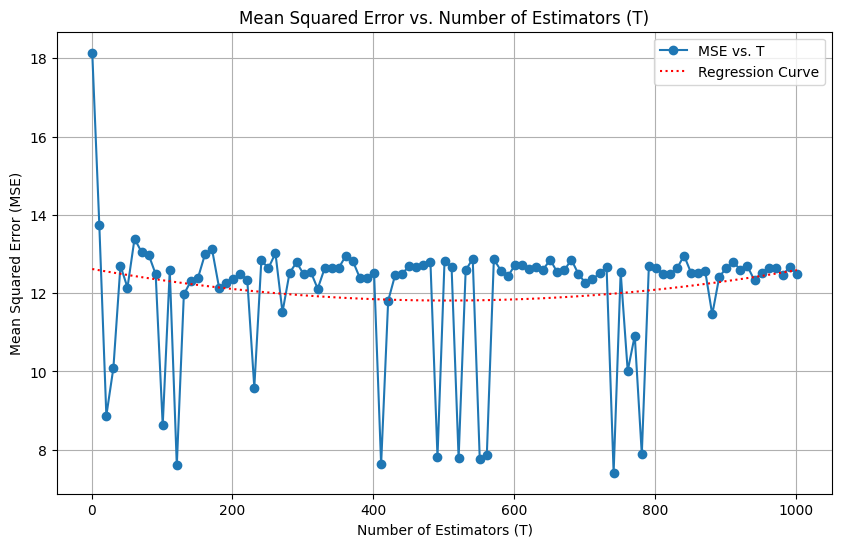

In [43]:
def regression_curve(x, y):
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    return p(x)
T_values = list(range(1, 1002, 10))
mse_values = []
for t in T_values:
    ada_boost_regressor = AdaBoostR2()
    ada_boost_regressor.fit(X_train, y_train, T=t, tree_depth=20, random_state=None)
    y_pred_adaboost = ada_boost_regressor.predict(X_test)
    mse_adaboost = mean_squared_error(y_test, y_pred_adaboost)
    mse_values.append(mse_adaboost)

reg_curve_values = regression_curve(T_values, mse_values)
plt.figure(figsize=(10, 6))

plt.plot(T_values, mse_values, marker='o', label='MSE vs. T')
plt.plot(T_values, reg_curve_values, linestyle='dotted', color='red', label='Regression Curve')

plt.title('Mean Squared Error vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

### Number of Estimators vs Training time

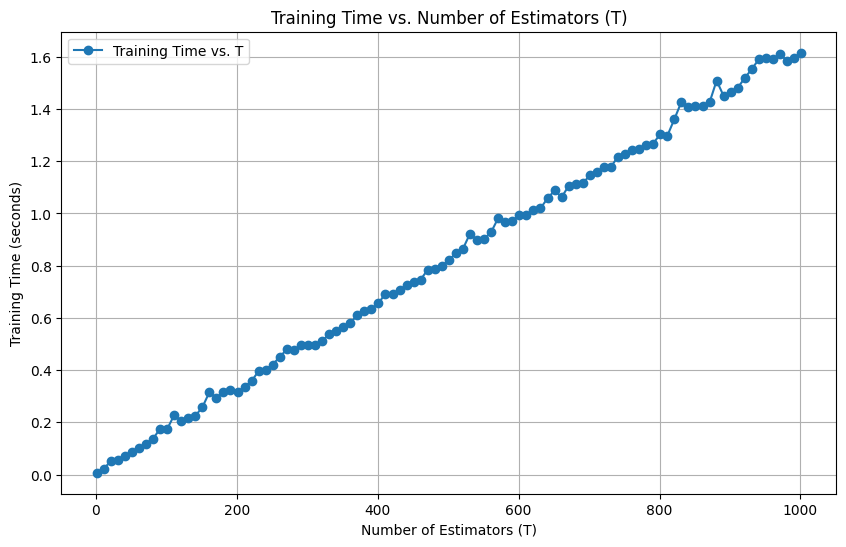

In [45]:
T_values = list(range(1, 1002, 10))
training_times = []

for t in T_values:
    start_time = time.time()
    
    ada_boost_regressor = AdaBoostR2()
    ada_boost_regressor.fit(X_train, y_train, T=t, tree_depth=20, random_state=None)
    
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

plt.figure(figsize=(10, 6))
plt.plot(T_values, training_times, marker='o', label='Training Time vs. T')

plt.title('Training Time vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

## Gradient Boosted Decision Trees (Regression)

In [46]:
class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def fit(self, X_train, y_train):
        initial_prediction = np.mean(y_train)
        predictions = np.full_like(y_train, initial_prediction)

        for _ in range(self.n_estimators):
            residuals = y_train - predictions
            tree = DecisionTreeRegressor(max_depth=3)
            tree.fit(X_train, residuals)
            prediction_update = self.learning_rate * tree.predict(X_train)
            predictions += prediction_update
            self.models.append(tree)

    def predict(self, X_test):
        predictions = np.full(X_test.shape[0], np.mean(y_train))

        for tree in self.models:
            prediction_update = self.learning_rate * tree.predict(X_test)
            predictions += prediction_update
        return predictions

gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
gb_regressor.fit(X_train, y_train)
y_pred = gb_regressor.predict(X_test)
print(mean_squared_error(y_test, y_pred))

7.5896115805132744


### Number of Estimators vs MSE

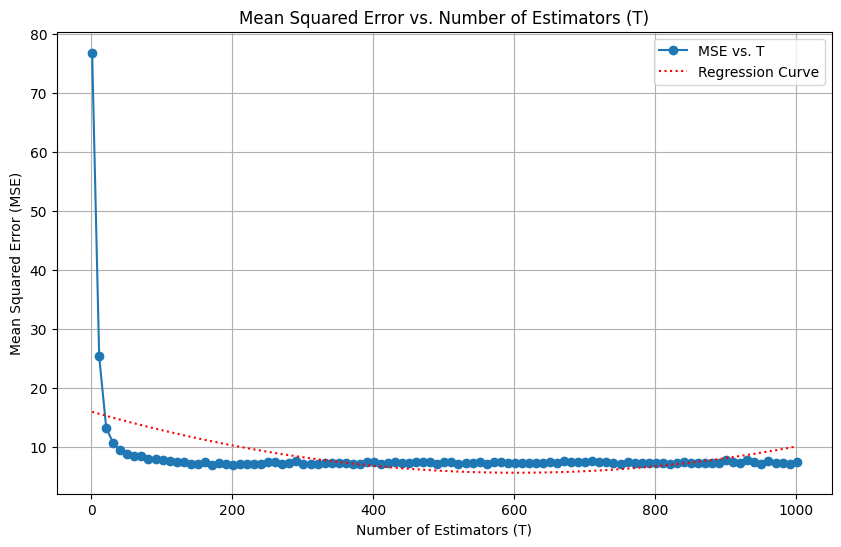

In [48]:
def regression_curve(x, y):
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    return p(x)
T_values = list(range(1, 1002, 10))
mse_values = []
for t in T_values:
    gb_regressor = GradientBoostingRegressor(n_estimators=t, learning_rate=0.1)
    gb_regressor.fit(X_train, y_train)
    y_pred = gb_regressor.predict(X_test)
    mse_gb = mean_squared_error(y_test, y_pred)
    mse_values.append(mse_gb)

reg_curve_values = regression_curve(T_values, mse_values)
plt.figure(figsize=(10, 6))

plt.plot(T_values, mse_values, marker='o', label='MSE vs. T')
plt.plot(T_values, reg_curve_values, linestyle='dotted', color='red', label='Regression Curve')

plt.title('Mean Squared Error vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

### Number of Estimators vs Training Time

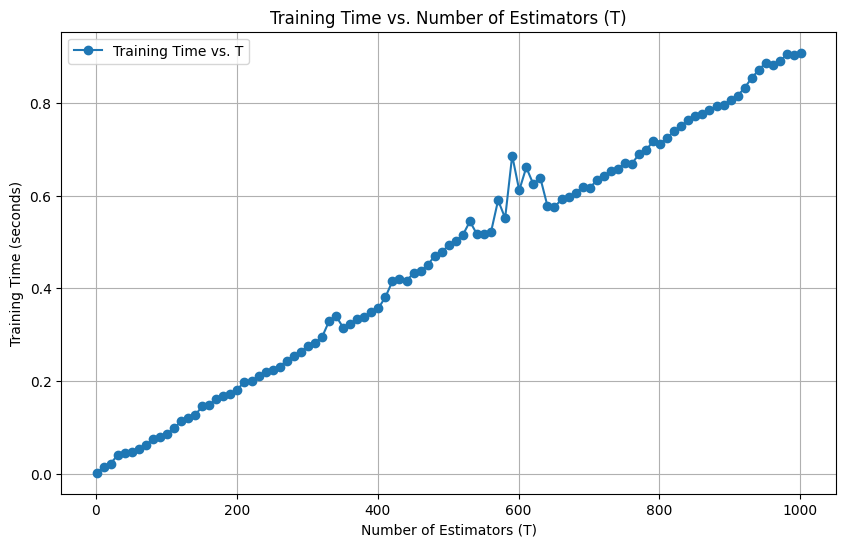

In [49]:
T_values = list(range(1, 1002, 10))
training_times = []

for t in T_values:
    start_time = time.time()
    gb_regressor = GradientBoostingRegressor(n_estimators=t, learning_rate=0.1)
    gb_regressor.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

plt.figure(figsize=(10, 6))
plt.plot(T_values, training_times, marker='o', label='Training Time vs. T')

plt.title('Training Time vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
data = pd.read_csv('WineQT.csv', header=0)
data['quality'].replace({3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1}, inplace=True)
train_data, test_data = train_test_split(data, test_size=0.2,random_state = 42)

scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

imputer = SimpleImputer(strategy='mean')  

train_data_scaled = scaler.fit_transform(imputer.fit_transform(train_data.drop(columns=['quality'])))
train_labels = train_data['quality']

test_data_scaled = scaler.transform(imputer.transform(test_data.drop(columns=['quality'])))

train_data_scaled_normalized = minmax_scaler.fit_transform(train_data_scaled)
test_data_scaled_normalized = minmax_scaler.transform(test_data_scaled)

X_train = train_data_scaled
y_train = train_labels
X_test = test_data_scaled
y_test = test_data['quality']

y_train = np.array(y_train)
y_test = np.array(y_test)
print(y_test)


[0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1
 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1
 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1
 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0
 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0
 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 0 1 0 1 1]


# Random Forest Classification

In [19]:
def random_forest_ensemble_classification(n_estimators, sample_fraction, with_replacement, voting):
    ensemble_models = []
    
    sample_size = int(sample_fraction * len(X_train))
    for _ in range(n_estimators):
        sample_indices = np.random.choice(len(X_train), size=sample_size, replace=with_replacement)
        sample_X = X_train[sample_indices]  
        sample_y = y_train[sample_indices]
        base_model = DecisionTreeClassifier(max_features="sqrt")
        sample_y = np.array(sample_y)
        base_model.fit(sample_X, sample_y)
        ensemble_models.append(base_model)

    def ensemble_predict(X):
        predictions = [model.predict(X) for model in ensemble_models]
        predictions = np.array(predictions)
        if voting == "hard":
            column_sums = np.sum(predictions, axis=0)
            array_2d = (column_sums > (len(predictions) / 2)).astype(int)
            return array_2d
        elif voting == "soft":
            confidences = [accuracy_score(y_test, model.predict(X_test)) for model in ensemble_models]
            confidences = confidences / sum(confidences)
            prediction = []
            for i in range(len(confidences)):
                prediction.append(predictions[i] * confidences[i])
            prediction = np.array(prediction)
            array_2d = np.sum(prediction, axis=0) > 0.5
            array_2d = array_2d.astype(int)
            return array_2d
    return ensemble_predict


bagged_classifier_decision_tree_soft = random_forest_ensemble_classification(n_estimators=10, sample_fraction=0.75, with_replacement=True, voting="hard")

y_pred = bagged_classifier_decision_tree_soft(X_test)
y_pred = np.array(y_pred)
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.759825327510917


### Hyperparameter Tuning

In [ ]:
n_estimators = [1,10,50,100,500,1000]
sample_fraction = [0.15,0.25,0.5,0.75,1]
bootstrap = [True,False]
voting = ["soft","hard"]
best_accuracy = 0
best_params = []
for i in n_estimators:
    for k in sample_fraction:
        for l in bootstrap:
            for m in voting:
                bagged_classifier = random_forest_ensemble_classification(n_estimators=i, sample_fraction=k, with_replacement=l, voting=m)
                y_pred = bagged_classifier(X_test)
                y_pred = np.array(y_pred)
                y_test = np.array(y_test)
                acc = accuracy_score(y_test, y_pred)
                print("Accuracy:", acc)
                print("n_estimators:",i)
                print("sample_fraction:",k)
                print("bootstrap:",l)
                print("voting:",m)
                print("-----------------------------------------------------")
                if(acc >= best_accuracy):
                    best_accuracy = acc
                    best_params = [i,k,l,m]
print("Best Accuracy:",best_accuracy)
print("Best Parameters:",best_params)     

## Decision Tree + Adaboost (Classification)

In [22]:
class AdaBoostBinaryClassifier:
    
    def fit(self, X_train, y_train, T, tree_depth=1):
        self.y_train, self.X_train, self.N, self.D = y_train, X_train, X_train.shape[0], X_train.shape[1]
        self.T, self.tree_depth = T, tree_depth
        self.weights = np.repeat(1 / self.N, self.N)
        self.classifiers, self.alphas, self.predictions = [], [], np.empty((self.N, self.T))
        
        for t in range(self.T):
            clf_t = DecisionTreeClassifier(max_depth=self.tree_depth)
            clf_t.fit(self.X_train, self.y_train, sample_weight=self.weights)
            pred_t = clf_t.predict(self.X_train)
            epsilon_t = sum(self.weights * (pred_t != self.y_train)) / sum(self.weights)
            alpha_t = np.log((1 - epsilon_t) / epsilon_t)
            new_weights = []
            for i, w in enumerate(self.weights):
                if pred_t[i] != self.y_train[i]:
                    updated_weight = w * np.exp(alpha_t)
                else:
                    updated_weight = w * np.exp(-alpha_t)

                new_weights.append(updated_weight)
            self.weights = np.array(new_weights)
            self.weights /= sum(self.weights)
            self.classifiers.append(clf_t)
            self.alphas.append(alpha_t)
            self.predictions[:, t] = pred_t
            
        self.y_pred = np.sign(np.dot(self.predictions, self.alphas))
        
    def predict(self, X_test):
        predictions = np.zeros(len(X_test))
        for t, clf in enumerate(self.classifiers):
            predictions += clf.predict(X_test) * self.alphas[t]
        return np.sign(predictions)
adaboost_classifier = AdaBoostBinaryClassifier()
adaboost_classifier.fit(X_train, y_train, T=1, tree_depth=5)
y_pred_adaboost = adaboost_classifier.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
print("AdaBoost Accuracy:", accuracy_adaboost)

AdaBoost Accuracy: 0.7379912663755459


### Number of Estimators vs Accuracy

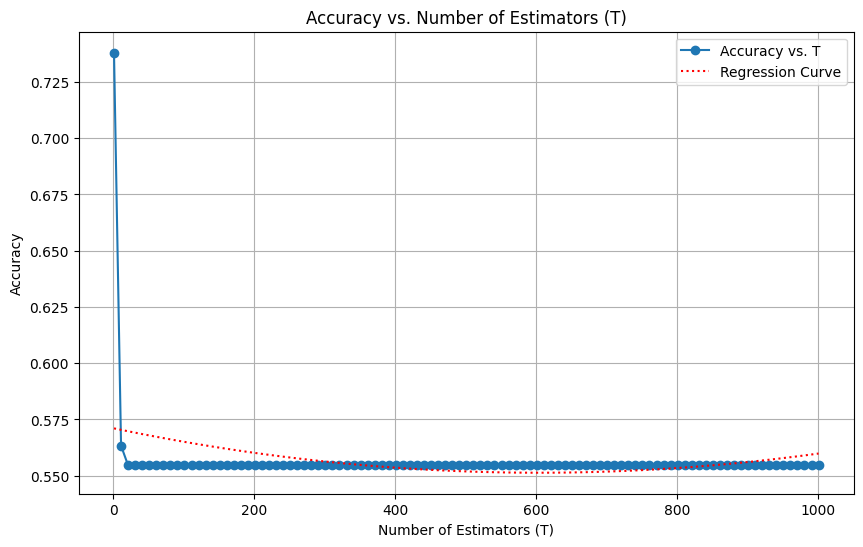

In [21]:
# For Depth = 5
def regression_curve(x, y):
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    return p(x)
T_values = list(range(1, 1002, 10))
acc_values = []
for t in T_values:
    adaboost_classifier = AdaBoostBinaryClassifier()
    adaboost_classifier.fit(X_train, y_train, T=t, tree_depth=5)
    y_pred_adaboost = adaboost_classifier.predict(X_test)
    accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
    acc_values.append(accuracy_adaboost)

reg_curve_values = regression_curve(T_values, acc_values)
plt.figure(figsize=(10, 6))

plt.plot(T_values, acc_values, marker='o', label='Accuracy vs. T')
plt.plot(T_values, reg_curve_values, linestyle='dotted', color='red', label='Regression Curve')

plt.title('Accuracy vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Number of Estimators vs Training Time

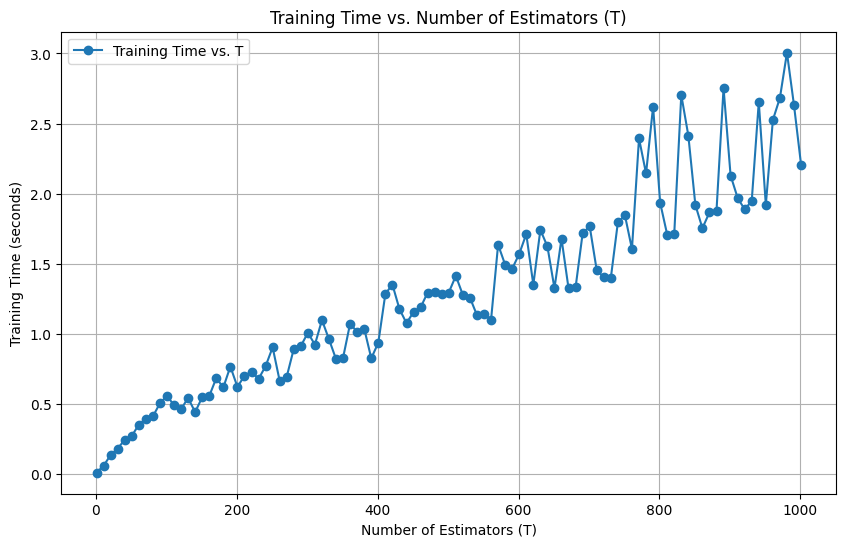

In [22]:
T_values = list(range(1, 1002, 10))
training_times = []

for t in T_values:
    start_time = time.time()
    adaboost_classifier = AdaBoostBinaryClassifier()
    adaboost_classifier.fit(X_train, y_train, T=t, tree_depth=5)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

plt.figure(figsize=(10, 6))
plt.plot(T_values, training_times, marker='o', label='Training Time vs. T')

plt.title('Training Time vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

## Gradient Boosted Decision Tree Classification

In [26]:
class GradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X_train, y_train):
        initial_prediction = np.log(np.mean(y_train) / (1 - np.mean(y_train)))
        predictions = [initial_prediction]*len(y_train)
        predictions = np.array(predictions)
        for _ in range(self.n_estimators):
            logits = self.sigmoid(predictions)
            residuals = y_train - logits
            residuals = np.array(residuals)
            tree = DecisionTreeRegressor(max_depth=3)
            tree.fit(X_train, residuals)
            prediction_update = self.learning_rate * tree.predict(X_train)
            predictions += prediction_update
            self.models.append(tree)

    def predict_proba(self, X_test):
        predictions = [np.log(np.mean(y_train) / (1 - np.mean(y_train)))]*len(X_test)
        predictions = np.array(predictions)
        for tree in self.models:
            prediction_update = self.learning_rate * tree.predict(X_test)
            predictions += prediction_update
        probabilities = self.sigmoid(predictions)
        return np.column_stack((1 - probabilities, probabilities))

    def predict(self, X_test, threshold=0.5):
        probabilities = self.predict_proba(X_test)[:, 1]
        return (probabilities >= threshold).astype(int)

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7729257641921398


### Number of estimators vs Accuracy

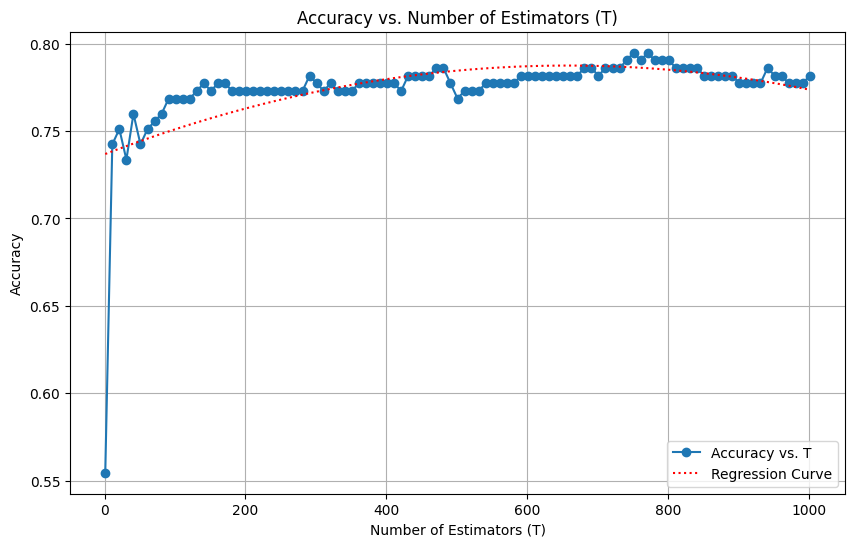

In [27]:
# For Depth = 5
def regression_curve(x, y):
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    return p(x)
T_values = list(range(1, 1002, 10))
acc_values = []
for t in T_values:
    gb_classifier = GradientBoostingClassifier(n_estimators=t, learning_rate=0.1)
    gb_classifier.fit(X_train, y_train)
    y_pred = gb_classifier.predict(X_test)
    accuracy_gb = accuracy_score(y_test, y_pred)
    acc_values.append(accuracy_gb)

reg_curve_values = regression_curve(T_values, acc_values)
plt.figure(figsize=(10, 6))

plt.plot(T_values, acc_values, marker='o', label='Accuracy vs. T')
plt.plot(T_values, reg_curve_values, linestyle='dotted', color='red', label='Regression Curve')

plt.title('Accuracy vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Number of estimators vs Training time

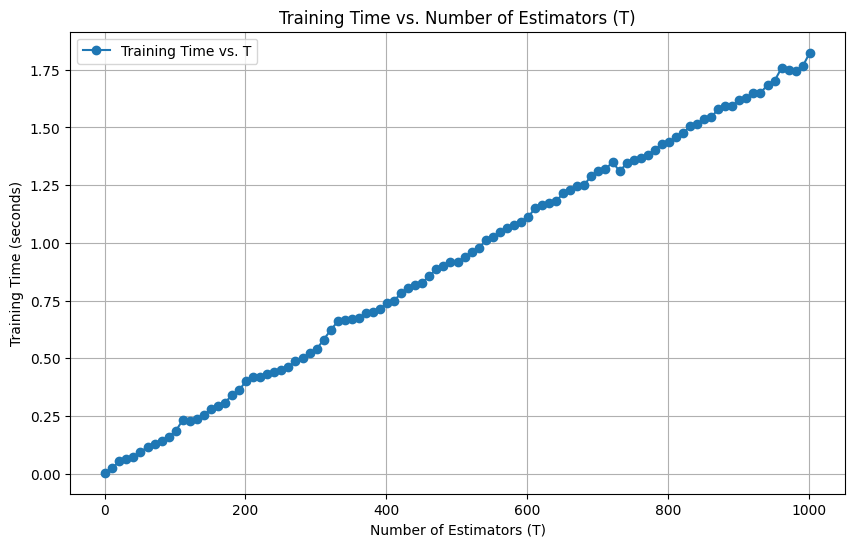

In [28]:
T_values = list(range(1, 1002, 10))
training_times = []

for t in T_values:
    start_time = time.time()
    gb_classifier = GradientBoostingClassifier(n_estimators=t, learning_rate=0.1)
    gb_classifier.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

plt.figure(figsize=(10, 6))
plt.plot(T_values, training_times, marker='o', label='Training Time vs. T')

plt.title('Training Time vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

# Analysis

## RandomForest:

**Strengths:**
- Robust and less prone to overfitting.
- Can capture complex relationships.
- Performs well on high-dimensional datasets.

**Weaknesses:**
- May struggle with subtle patterns.
- Computationally expensive for large datasets.

**Common Mistakes:**
- Difficulty capturing highly complex, non-linear relationships.
- Misclassification of outliers or noise.

## DecisionTree with Adaboost:

**Strengths:**
- Boosts performance of weak learners.
- Less prone to overfitting compared to single Decision Tree.

**Weaknesses:**
- Sensitive to noisy data and outliers.
- Struggles with overly complex or too simple weak learners.

**Common Mistakes:**
- Misclassification of instances challenging for weak learners.
- Influenced by outliers or noise.

## Gradient Boosted Decision Trees:

**Strengths:**
- Optimizes weaknesses of weak learners iteratively.
- Performs well on various tasks.

**Weaknesses:**
- Sensitive to hyperparameter tuning.
- Requires more computational resources.

**Common Mistakes:**
- Potential overfitting if not properly regularized.
- Affected by outliers or noise.

## Exploring Feature Similarity of Common Mistakes:

### Steps:

1. **Collect Misclassified Instances:**
   - Identify instances consistently misclassified by all three models.

2. **Feature Analysis:**
   - Analyze features of misclassified instances.
   - Look for common patterns or similarities.

3. **Dimensionality Reduction:**
   - Use PCA for visualizing feature patterns.
   - Identify clusters or patterns in misclassified instances.

4. **Outlier Detection:**
   - Check for outliers or anomalies in misclassified instances.
   - Evaluate their impact on model decisions.

5. **Feature Importance:**
   - Analyze feature importance scores from the models.
   - Identify features consistently contributing to misclassifications.

By understanding common mistakes and exploring associated features, insights can be gained into model limitations. Improvements may be made through feature engineering, data preprocessing, or hyperparameter adjustments.
